<a href="https://colab.research.google.com/github/pipeton8/6.439-stats-comp-applications/blob/main/Assignments/3%20-%20Economics/6.439%20-%20Problem%20Set%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Set 3 - Statistics, Computation and Applications

(c) Felipe del Canto, October 2021
***
***

# Part 0 (Execute first!)

In [77]:
from IPython.display import clear_output

# Download files
!wget https://github.com/pipeton8/6.439-stats-comp-applications/raw/main/Assignments/databases/PS3_data.zip

# Unzip
!unzip -o PS3_data.zip
!rm *.z* -r __MACOSX

# Clear output
clear_output()

# Import packages
import datetime
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm, trange

import statsmodels.api         as sm
import statsmodels.formula.api as smf

In [96]:
def fit_npoly_trend(data=None, dep='', n=1, predict=False, residuals=False, sufix='', verbose=True):
  formula = dep + ' ~ ' + '+'.join(['t' + f'_{i:d}'*(i>1) for i in range(1,n+1)])
  
  ols = smf.ols(formula=formula, data=data, missing='drop', hasconst=False).fit()

  if verbose:
    print(ols_a.summary())

  if predict or residuals:
    predict_from_model(data, dep, ols, sufix, store_predict=predict, residuals=residuals)
  
  return ols

In [90]:
def predict_from_model(data, dep, model, sufix, store_predict=True, residuals=False):
  pred_var = dep + '_pred' + sufix
  data.loc[~data[dep].isna(), pred_var] = model.predict()

  if residuals:
    data['res'+sufix] = data[dep] - data[pred_var]

  if not store_predict:
    newcols = list(data.columns).remove(pred_var)
    data = data[newcols]

  return None

# Part 1

## Problem 3.1: The Manua Loa $\text{CO}_2$ concentration.

In [78]:
# Write column names
old_colnames = ['year', 'month', 'date_excel', 'date_num', 'co2',
            'co2_season_adj', # season adjusted using substracting 4-harmonic fit
            'co2_fit',        # cubic spline
            'co2_season_adj_fit', # fit substracting season adj
            'co2_filled',         # filled with co2_fit
            'co2_season_adj_filled'] # season adjusted column filled with co2_season_adj_fit

# Load data
co2_data = pd.read_csv('CO2Data.csv',index_col=False, names=old_colnames, skiprows=59)

# Replace missing values with NANs
missing_value_code = -99.99
co2_data.replace(to_replace = missing_value_code, value=pd.NA, inplace=True)

# Create date variable
co2_data['date'] = co2_data['year'].apply(str) + "/" + co2_data['month']. apply(str) + "/15"
co2_data['date'] = pd.to_datetime(co2_data['date'], format="%Y/%m/%d")

# Delete date_excel and date_num columns
colnames = ['date'] + [colname for colname in old_colnames if colname.find("date") == -1]
co2_data = co2_data[colnames]

In [79]:
co2_data.describe(include='all', datetime_is_numeric=True)

,date,year,month,co2,co2_season_adj,co2_fit,co2_season_adj_fit,co2_filled,co2_season_adj_filled
count,706,706.00,706.00,698.00,698.00,703.00,703.00,703.00,703.00
mean,1987-07-31 06:21:24.985835712,1987.08,6.51,352.00,351.99,351.76,351.74,351.76,351.75
min,1958-03-15 00:00:00,1958.00,1.00,313.21,314.42,312.44,314.90,312.44,314.42
25%,1972-11-22 12:00:00,1972.00,4.00,328.48,328.93,328.32,328.19,328.11,328.28
50%,1987-07-30 12:00:00,1987.00,7.00,349.53,349.54,349.30,348.85,348.96,348.76
75%,2002-04-07 06:00:00,2002.00,9.75,372.76,372.27,372.24,372.09,372.28,372.15
max,2016-12-15 00:00:00,2016.00,12.00,407.65,404.73,407.23,404.62,407.65,404.73
std,NaN,17.00,3.45,25.96,25.87,26.02,25.94,26.02,25.94


### (a)

#### Fit and predict linear model with residuals 

In [97]:
fit_kwargs_a = {'data'      : co2_data,
                'dep'       : 'co2',
                'n'         : 1,
                'predict'   : True,
                'residuals' : True,
                'sufix'     : '_a'}

ols_a = fit_npoly_trend(**fit_kwargs_a)

                                 OLS Regression Results                                
Dep. Variable:                    co2   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.885e+06
Date:                Tue, 19 Oct 2021   Prob (F-statistic):                        0.00
Time:                        19:49:56   Log-Likelihood:                         -1936.2
No. Observations:                 698   AIC:                                      3876.
Df Residuals:                     696   BIC:                                      3885.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

#### Plot fit

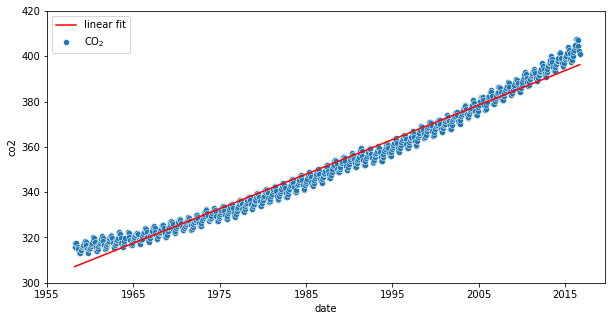

In [98]:
# Initialize figure
fig, ax = plt.subplots()
fig.set_size_inches(10,5)

# Draw scatterplot and fit
sns.scatterplot(data=co2_data, x='date', y='co2', label=r'CO$_2$', ax=ax)
sns.lineplot(data=co2_data, x='date', y='co2_pred', label='linear fit', color = 'red', ax=ax)

# Set xticks and yticks
xticks = [f'{1955+10*k:d}' for k in range(7)]
yticks = [300 + 20*k for k in range(7)]

plt.xticks(pd.to_datetime(xticks), xticks)
plt.yticks(yticks)

# Set legend location
plt.legend(loc='upper left')

# Show figure
fig.show()

#### Plot residuals

In [106]:
co2_data['res_a'].describe()

count   698.00
mean     -0.00
std       3.88
min      -7.56
25%      -2.76
50%      -0.39
75%       2.39
max      11.91
Name: res_a, dtype: float64

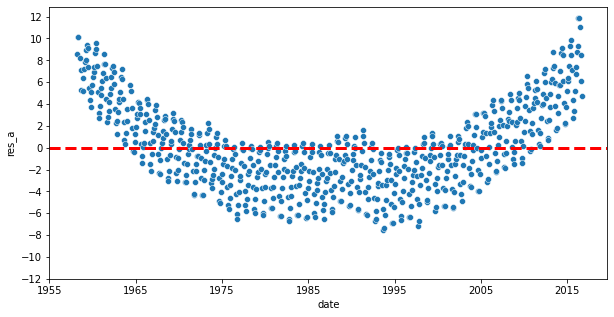

In [109]:
# Initialize figure
fig, ax = plt.subplots()
fig.set_size_inches(10,5)

# Draw scatterplot and fit
sns.scatterplot(data=co2_data, x='date', y='res_a', ax=ax)
plt.axhline(linestyle='--', linewidth = 3, color = 'red')

# Set xticks and yticks
xticks = [f'{1955+10*k:d}' for k in range(7)]
yticks = [-12 + 2*k for k in range(13)]

plt.xticks(pd.to_datetime(xticks), xticks)
plt.yticks(yticks)

# Show figure
fig.show()

#### Compute and plot ACF

In [114]:
acf_kwargs_a = {'nlags'   : 40,
                'missing' : 'conservative',
                'fft'     : True}

corr = sm.tsa.acf(co2_data['res_a'], **acf_kwargs_a)

[1.         0.93123153 0.79972051 0.6469538  0.52735968 0.43845082
 0.40396873 0.4212976  0.49309568 0.60908887 0.74564271 0.85976248
 0.9023256  0.85074139 0.726401   0.57695724 0.44955449 0.36628055
 0.33521775 0.35209575 0.42158786 0.53589398 0.67139698 0.78343094
 0.82534477 0.77442128 0.65212435 0.50633874 0.3801309  0.29903665
 0.26841004 0.28646657 0.35464863 0.46692276 0.6001932  0.71051861
 0.75127155 0.70055302 0.58016994 0.43701936 0.31301049]


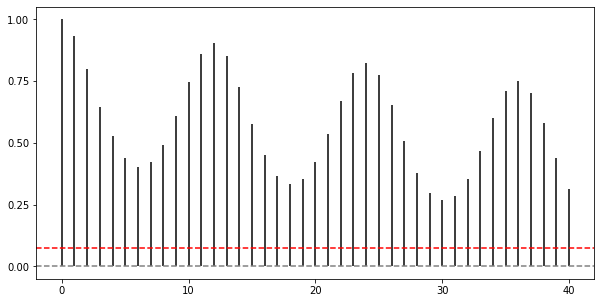

In [129]:
# Initialize figure
fig, ax = plt.subplots()
fig.set_size_inches(10,5)

# Draw scatterplot and fit
N = co2_data['co2'].notna().sum()
z_alpha = 1.96/np.sqrt(N)

lags = [i for i in range(acf_kwargs_a['nlags']+1)]
plt.axhline(y=z_alpha, linestyle='--', color = 'red')
plt.axhline(y=0, linestyle='--', color = 'gray')
plt.vlines(lags,0,corr)

# Set xticks and yticks
xticks = [10*k for k in range(5)]
yticks = [0.25*k for k in range(5)]

plt.xticks(xticks)
plt.yticks(yticks)

# Show figure
fig.show()

### (b)

### (c)

### (d)

### (e)

## Problem 3.1: BPP Data Analysis

### (a)

### (b)

### (c)

### (d)

### (e)

### (f)